In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report




In [2]:
df = pd.read_csv("data/raw/cyfercode_security_events_v2.csv")
df.head()


,event_type,src_ip_type,dst_port,protocol,alert_signature,failed_attempts,session_duration,bytes_sent,is_cloud_asset,alert_severity,label
0,firewall,internal,21,tcp,normal,1,66,47,1,low,0
1,cloud,internal,53,tcp,normal,5,209,2915,1,low,0
2,auth,internal,25,tcp,normal,2,677,11857,0,low,0
3,firewall,internal,3389,tcp,normal,3,53,2847,0,low,0
4,ids,internal,443,tcp,normal,3,70,2654,0,low,0


In [3]:
df.columns


Index(['event_type', 'src_ip_type', 'dst_port', 'protocol', 'alert_signature',
       'failed_attempts', 'session_duration', 'bytes_sent', 'is_cloud_asset',
       'alert_severity', 'label'],
      dtype='object')

In [4]:
# ================================
# Baseline V2-A: Signature-Reduced
# ================================

df_v2a = df.copy()

# Normalize alert_signature
df_v2a["alert_signature"] = df_v2a["alert_signature"].str.lower()

# High-level behavioral flags
df_v2a["is_known_attack_signature"] = df_v2a["alert_signature"].isin(
    ["malware", "bruteforce", "port_scan"]
).astype(int)

df_v2a["is_recon_activity"] = df_v2a["alert_signature"].isin(
    ["port_scan"]
).astype(int)

df_v2a["is_auth_attack"] = df_v2a["alert_signature"].isin(
    ["bruteforce"]
).astype(int)

df_v2a["is_malware_related"] = df_v2a["alert_signature"].isin(
    ["malware"]
).astype(int)

# Drop raw signature
df_v2a = df_v2a.drop(columns=["alert_signature"])


In [5]:
df_v2a.columns


Index(['event_type', 'src_ip_type', 'dst_port', 'protocol', 'failed_attempts',
       'session_duration', 'bytes_sent', 'is_cloud_asset', 'alert_severity',
       'label', 'is_known_attack_signature', 'is_recon_activity',
       'is_auth_attack', 'is_malware_related'],
      dtype='object')

In [6]:
y = df_v2a["label"]

num_features = [
    "dst_port",
    "failed_attempts",
    "session_duration",
    "bytes_sent"
]

cat_features = [
    "event_type",
    "src_ip_type",
    "protocol",
    "alert_severity",
    "is_cloud_asset",
    "is_known_attack_signature",
    "is_recon_activity",
    "is_auth_attack",
    "is_malware_related"
]

X = df_v2a[num_features + cat_features]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [8]:
numeric_pipeline = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_pipeline = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features)
    ]
)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ]
)


In [9]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['dst_port',
                                                   'failed_attempts',
                                                   'session_duration',
                                                   'bytes_sent']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['event_type', 'src_ip_type',
                                                   'protocol', 'alert_severity',
                                                   'is_cloud_asset',
                                                   'is_known_attack_signature',
                                                   'is_recon_activity',
                                                   'is_auth_attack',
                                                   'is_malware_related'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [10]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

thresholds = [0.9, 0.7,0.6, 0.5, 0.4, 0.3]
rows = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    rows.append({
        "threshold": t,
        "attack_recall": tp / (tp + fn),
        "false_positives": fp,
        "true_positives": tp
    })

threshold_df_v2a = pd.DataFrame(rows)
threshold_df_v2a


,threshold,attack_recall,false_positives,true_positives
0,0.9,0.99115,0,1232
1,0.7,1.00000,0,1243
2,0.6,1.00000,0,1243
3,0.5,1.00000,0,1243
4,0.4,1.00000,4,1243
5,0.3,1.00000,5,1243


In [11]:
SELECTED_THRESHOLD = 0.7

y_pred = (y_proba >= SELECTED_THRESHOLD).astype(int)

print("Baseline V2-A Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Baseline V2-A Confusion Matrix:
[[4401    0]
 [   0 1243]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4401
           1       1.00      1.00      1.00      1243

    accuracy                           1.00      5644
   macro avg       1.00      1.00      1.00      5644
weighted avg       1.00      1.00      1.00      5644



In [12]:

# ==========================================
# Feature Importance for Baseline V2-A
# ==========================================

# Get transformed feature names from preprocessor
feature_names = pipeline.named_steps[
    "preprocessor"
].get_feature_names_out()

# Get Logistic Regression coefficients
coefficients = pipeline.named_steps[
    "classifier"
].coef_[0]

# Create feature importance DataFrame
feature_importance_v2a = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients,
        "abs_coefficient": np.abs(coefficients)
    })
    .sort_values("abs_coefficient", ascending=False)
    .reset_index(drop=True)
)

feature_importance_v2a.head(15)


,feature,coefficient,abs_coefficient
0,cat__is_known_attack_signature_1,4.768923,4.768923
1,cat__alert_severity_low,-4.613737,4.613737
2,cat__is_known_attack_signature_0,-4.047532,4.047532
3,cat__alert_severity_high,2.821293,2.821293
4,cat__src_ip_type_external,2.520060,2.520060
5,cat__alert_severity_medium,2.513834,2.513834
6,cat__is_malware_related_1,2.226370,2.226370
7,cat__src_ip_type_internal,-1.798670,1.798670
8,cat__is_recon_activity_1,1.790598,1.790598
9,num__dst_port,-1.678840,1.678840


In [13]:
# ================================
# Baseline V2-B: Signature-Free
# ================================

df_v2b = df.copy()

# Drop alert_signature entirely
df_v2b = df_v2b.drop(columns=["alert_signature"])


In [14]:
df_v2b.columns


Index(['event_type', 'src_ip_type', 'dst_port', 'protocol', 'failed_attempts',
       'session_duration', 'bytes_sent', 'is_cloud_asset', 'alert_severity',
       'label'],
      dtype='object')

In [15]:
y = df_v2b["label"]

num_features = [
    "dst_port",
    "failed_attempts",
    "session_duration",
    "bytes_sent"
]

cat_features = [
    "event_type",
    "src_ip_type",
    "protocol",
    "alert_severity",
    "is_cloud_asset"
]

X = df_v2b[num_features + cat_features]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [17]:
numeric_pipeline = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_pipeline = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features)
    ]
)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ]
)


In [18]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['dst_port',
                                                   'failed_attempts',
                                                   'session_duration',
                                                   'bytes_sent']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['event_type', 'src_ip_type',
                                                   'protocol', 'alert_severity',
                                                   'is_cloud_asset'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [19]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

thresholds = [0.9, 0.7,0.6, 0.5, 0.4, 0.3]
rows = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    rows.append({
        "threshold": t,
        "attack_recall": tp / (tp + fn),
        "false_positives": fp,
        "true_positives": tp
    })

threshold_df_v2b = pd.DataFrame(rows)
threshold_df_v2b


,threshold,attack_recall,false_positives,true_positives
0,0.9,0.989541,38,1230
1,0.7,0.996782,52,1239
2,0.6,0.996782,58,1239
3,0.5,0.998391,61,1241
4,0.4,0.999195,64,1242
5,0.3,1.000000,64,1243


In [20]:
SELECTED_THRESHOLD = 0.7  # choose based on threshold_df_v2b

y_pred = (y_proba >= SELECTED_THRESHOLD).astype(int)

print("Baseline V2-B Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Baseline V2-B Confusion Matrix:
[[4349   52]
 [   4 1239]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4401
           1       0.96      1.00      0.98      1243

    accuracy                           0.99      5644
   macro avg       0.98      0.99      0.99      5644
weighted avg       0.99      0.99      0.99      5644



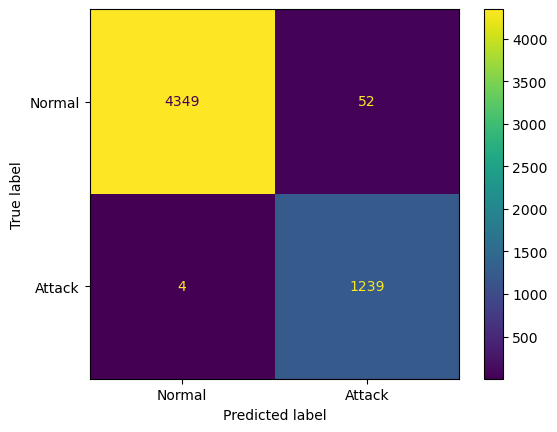

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Normal", "Attack"], values_format="d")
plt.show()



In [22]:
# ==========================================
# Feature Importance for Baseline V2-B
# ==========================================

# Get transformed feature names
feature_names = pipeline.named_steps[
    "preprocessor"
].get_feature_names_out()

# Get model coefficients
coefficients = pipeline.named_steps[
    "classifier"
].coef_[0]

# Build feature importance table
feature_importance_v2b = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients,
        "abs_coefficient": np.abs(coefficients)
    })
    .sort_values("abs_coefficient", ascending=False)
    .reset_index(drop=True)
)

feature_importance_v2b.head(15)


,feature,coefficient,abs_coefficient
0,cat__alert_severity_low,-8.900372,8.900372
1,cat__alert_severity_high,7.734594,7.734594
2,cat__alert_severity_medium,1.613792,1.613792
3,num__dst_port,-1.379699,1.379699
4,cat__src_ip_type_external,0.589193,0.589193
5,cat__protocol_udp,0.347679,0.347679
6,cat__is_cloud_asset_1,0.309778,0.309778
7,num__failed_attempts,-0.289641,0.289641
8,cat__event_type_ids,0.278314,0.278314
9,cat__event_type_cloud,0.191405,0.191405


In [23]:
import joblib
import os

os.makedirs("models", exist_ok=True)

joblib.dump(
    pipeline,
    "models/siem_lr_v2b_pipeline.joblib"
)

print("Pipeline saved successfully (V2-B)")


Pipeline saved successfully (V2-B)


In [24]:
# ==========================================
# ROC Curve & AUC – Final Model Validation
# ==========================================

from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)

# Compute AUC
auc_score = roc_auc_score(y_test, y_proba)

print("Baseline V2-B ROC-AUC Score:", round(auc_score, 4))


Baseline V2-B ROC-AUC Score: 0.9995


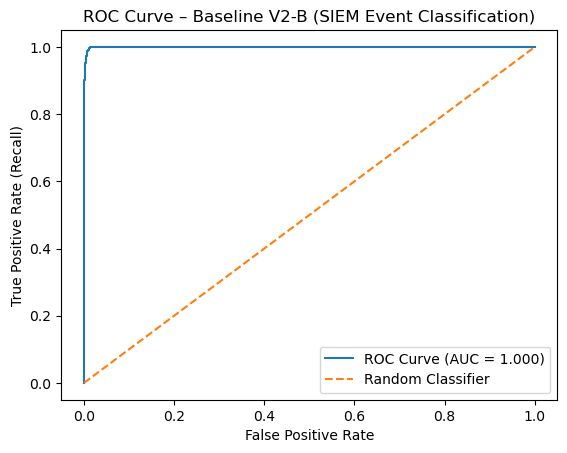

In [25]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Baseline V2-B (SIEM Event Classification)")
plt.legend()
plt.show()


In [ ]:
#The ROC-AUC score of 0.9995 indicates excellent class separability. 
#However, operational deployment relies on threshold selection based 
#on recall and false positive trade-offs rather than AUC alone.
